# Deep Dreams (with Caffe)

# python3 での修正箇所
- print の仕様変更に合わせる
- xrange を range に直す
- from cStringIO import StringIO を from io import ByteIO に
- StringIO を ByteIO に

In [3]:
# imports and basic notebook setup
# from cStringIO import StringIO
from io import BytesIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

##  DNN modelの入手
- [GoogLeNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet) model trained on [ImageNet](http://www.image-net.org/) 
- [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). 
- [MITのmodel](http://places.csail.mit.edu/downloadCNN.html) 
- [original blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

In [4]:
#model_path = '../models/finetune_flickr_style/' # substitute your path here
#net_fn   = model_path + 'deploy.prototxt'
#param_fn = model_path + 'finetune_flickr_style.caffemodel'
model_path = '../models/bvlc_googlenet/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # 平均値データ　一定値を引いたデータで訓練されている場合に用いる
                       channel_swap = (2,1,0)) # チャネルの入れ替え、RGBをBGRに入れ替えて処理

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

##  夢の生成の原理

夢画像は指定した特定のレイヤーでのL2ノルムを最大化することで生成される。
これは勾配法と似た手続きである。（最急降下の逆？）

  L2ノルム＝各成分自乗和の平方根

よい絵をつくるコツ

- * 画素の位置にランダムジッタ（ゆらぎ）を与える
- * 勾配法のステップの度合いを正規化する
- * 強調処理を複数段階にわたって適用する

ここではまず最初に基本的な勾配法のステップの関数を実装し、その後で上の２つを適用する。

途中にどんな層があるのかを表示

In [5]:
net.blobs.keys()

odict_keys(['data', 'conv1/7x7_s2', 'pool1/3x3_s2', 'pool1/norm1', 'conv2/3x3_reduce', 'conv2/3x3', 'conv2/norm2', 'pool2/3x3_s2', 'pool2/3x3_s2_pool2/3x3_s2_0_split_0', 'pool2/3x3_s2_pool2/3x3_s2_0_split_1', 'pool2/3x3_s2_pool2/3x3_s2_0_split_2', 'pool2/3x3_s2_pool2/3x3_s2_0_split_3', 'inception_3a/1x1', 'inception_3a/3x3_reduce', 'inception_3a/3x3', 'inception_3a/5x5_reduce', 'inception_3a/5x5', 'inception_3a/pool', 'inception_3a/pool_proj', 'inception_3a/output', 'inception_3a/output_inception_3a/output_0_split_0', 'inception_3a/output_inception_3a/output_0_split_1', 'inception_3a/output_inception_3a/output_0_split_2', 'inception_3a/output_inception_3a/output_0_split_3', 'inception_3b/1x1', 'inception_3b/3x3_reduce', 'inception_3b/3x3', 'inception_3b/5x5_reduce', 'inception_3b/5x5', 'inception_3b/pool', 'inception_3b/pool_proj', 'inception_3b/output', 'pool3/3x3_s2', 'pool3/3x3_s2_pool3/3x3_s2_0_split_0', 'pool3/3x3_s2_pool3/3x3_s2_0_split_1', 'pool3/3x3_s2_pool3/3x3_s2_0_split_2', 

In [6]:
def objective_L2(dst):
    dst.diff[:] = dst.data # 指定した層のデータ値を微係数としてセット

def make_step(net, step_size=1.5, end='inception_4c/output', 
#def make_step(net, step_size=1.5, end='conv4', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # 入力画像
    dst = net.blobs[end]    # 指定した層

    ox, oy = np.random.randint(-jitter, jitter+1, 2) # x,yそれぞれの方向のずらし幅を決める
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # シフトする
            
    net.forward(end=end) # end で指定した層まで順方向に計算してくる
    objective(dst)       # end層でのデータそのものを微係数としてセットし、
    net.backward(start=end)  # バックプロパゲーションして各層の微係数を計算
    g = src.diff[0] # 入力層で微係数を得る。これから得られる傾斜方向に値を変えれば目的とするL2ノルムが増える
    # 正規化勾配法を適用
    src.data[:] += step_size/np.abs(g).mean() * g
    # シフトした分をもとに戻す
    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)    

多重解像度画像として処理する。octave : １段階の縮小率　default 1.4 = sqrt(2)

In [7]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
#def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
#              end='conv4', clip=True, **step_params):
    # 多重解像度画像を準備　デフォルトは４段階
    octaves = [preprocess(net, base_img)]
    for i in range(octave_n-1):   # 各段階で、縦横 1/octave_scale 倍縮小画像をつくる
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data'] # 画像を data 層にセットするのではないことに注意

    detail = np.zeros_like(octaves[-1]) # 最も小さいレベルの画像と同サイズのゼロ画像
    
    # ここの処理はアンシャープマスクと似た考え。多重解像度画像を作っているが、より粗い画像は
    # 平滑化画像にほかならない。そのレベルで特徴を強調し、もとの画像との差分を詳細レベルの画像に
    # 加える、という操作を再帰的に実行している。
    for octave, octave_base in enumerate(octaves[::-1]): # 逆順（小さい方から順）に処理
        h, w = octave_base.shape[-2:] # 高さと幅
        if octave > 0: # 一番小さいのはそのまま、それ以外
            # 前段階（小さいサイズ）でできた detail を拡大する
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)
        src.reshape(1,3,h,w) # オクターブのサイズに合わせて入力層をリサイズ
        src.data[0] = octave_base+detail # 小さいサイズの結果を加える
        # for ループの１ループ目は detail はゼロなので、octave_baseつまり縮小画像そのものが
        # src.data[0]にセットされる。２ループ目以降はmake_stepで強調画像がつくられ、
        # それと元の画像との差分をとったものが detail の計算結果となる
        # 次のオクターブ処理では detail 画像をオクターブ画像に加算したものが処理対象となる。
        for i in range(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            # ↑指定した層での勾配データが最大化されるよう微係数を逆伝搬させて入力画像を変形
            # 
            vis = deprocess(net, src.data[0])
            if not clip: # ダイナミックレンジを拡大　下から99.98％位置のデータが255となるよう線形変換
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print( octave, i, end, vis.shape )
            clear_output(wait=True)
            
        # もとの画像との差分（強調分）の取り出し
        detail = src.data[0]-octave_base
    # 
    return deprocess(net, src.data[0])

準備完了

In [11]:
img = np.float32(PIL.Image.open('red.jpg'))

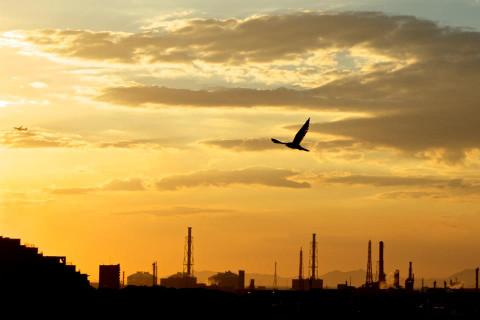

In [12]:
showarray(img)

# Deep Dreamの実行

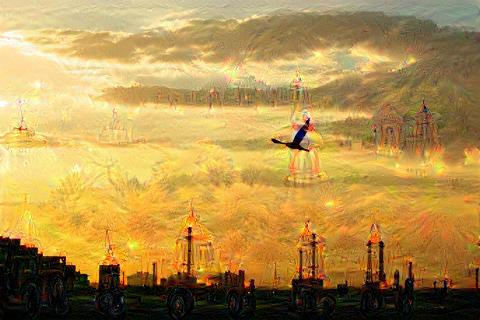

3 9 inception_4c/output (320, 480, 3)


In [14]:
_=deepdream(net, img) # デフォルト

end を変えてみる

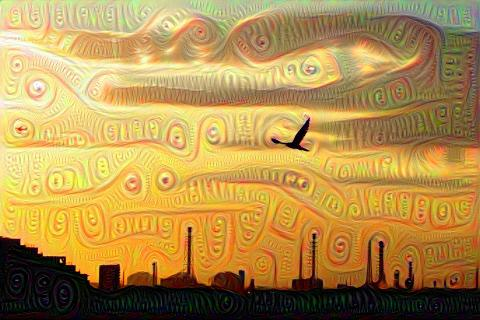

3 9 inception_3a/output (320, 480, 3)


In [13]:
_=deepdream(net, img, end='inception_3a/output')

次のブロックの１行目で frames というフォルダを作るので、もしすでにあるならリネームしておく

##### Controlling dreams

ここまでの方法では画像に含まれる特徴位置にそれから連想されるあらゆるイメージが重ねられたような結果が作られるのでいろんなものが各所に入り混じったような結果になる。

次は夢の誘導をためす。

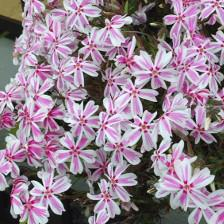

In [20]:
guide = np.float32(PIL.Image.open('flowers.jpg'))
showarray(guide)

GoogleNet では、訓練画像は 224x224, finetune_flickr_styleFsizeでは227x227のサイズにダウンサイジングされている。つまり、このサイズの区画に意味のあるオブジェクトが収まっているという前提で学習が行われているので、ここで使うガイド画像もそれに合わせておくのがよい。

In [21]:
# end = 'inception_3b/output'
end='inception_4d/output'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()
guide_features.shape

(528, 14, 14)

Instead of maximizing the L2-norm of current image activations, we try to maximize the dot-products between activations of current image, and their best matching correspondences from the guide image.

(528, 20, 30) (528, 14, 14)
(528, 600) (528, 196) 528


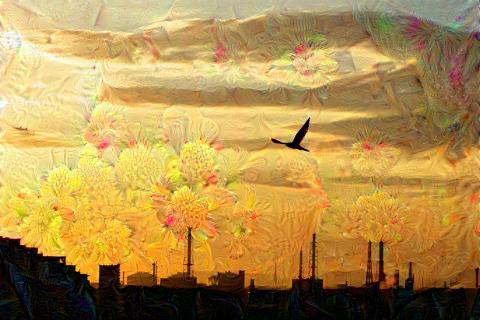

3 9 inception_4d/output (320, 480, 3)


In [22]:
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    print(x.shape,y.shape)
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    print(x.shape,y.shape,ch)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

_=deepdream(net, img, end=end, objective=objective_guide)

In [ ]:
!mkdir frames

In [28]:
frame = img2
frame_i = 0

(256, 39, 60) (256, 28, 28)
(256, 2340) (256, 784) 256


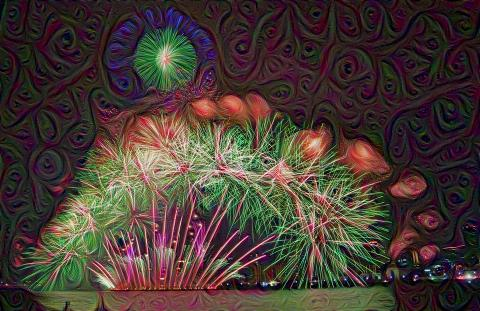

3 4 inception_3a/output (311, 480, 3)


In [34]:
h, w = frame.shape[:2]
s = 0.05 # スケーリング効果の割合
for i in range(3,10):
    frame = deepdream(net, img2, end='inception_3a/output', iter_n=5, objective=objective_guide)
    PIL.Image.fromarray(np.uint8(frame)).save("frames/fire%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1

In [27]:
img2 = np.float32(PIL.Image.open('firework.jpg'))

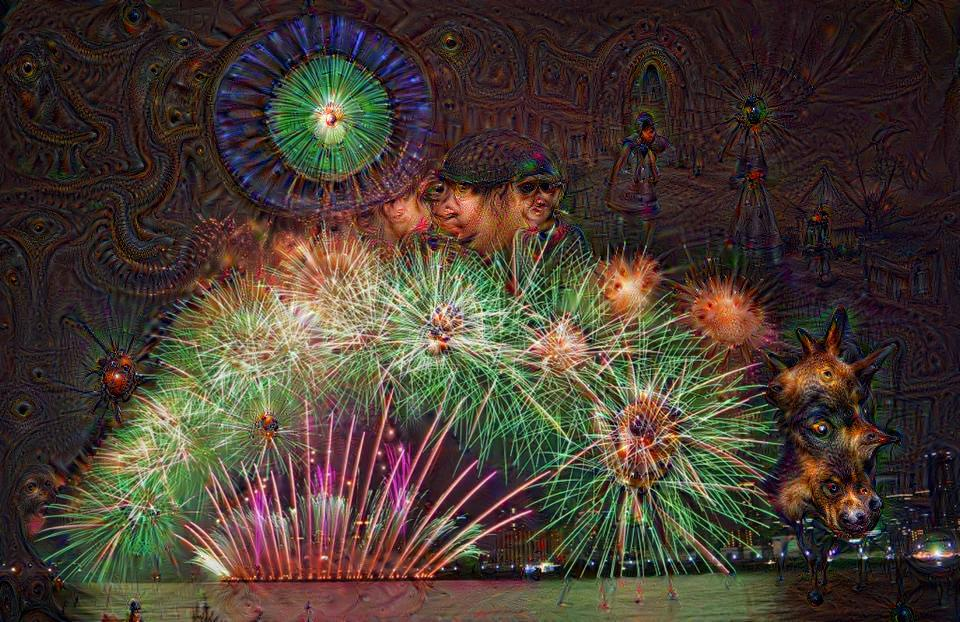

3 9 inception_4c/output (622, 960, 3)


In [19]:
_=deepdream(net, img2)

In [33]:
# end = 'inception_3b/output'
end='inception_3a/output'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()
guide_features.shape

(256, 28, 28)